<a href="https://colab.research.google.com/github/anarlavrenov/n2/blob/main/training_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import torch

import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [ ]:
# Загрузка данных
import torchaudio

dataset = torchaudio.datasets.LIBRISPEECH(".", url="train-clean-100", download=True)

# Фоновый шум
SAMPLE_NOISE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")
# Эффект исходной речи, но в другом пространстве
SAMPLE_RIR = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
noise, nsr = torchaudio.load(SAMPLE_NOISE)
rir_raw, rsr = torchaudio.load(SAMPLE_RIR)

100%|██████████| 5.95G/5.95G [07:40<00:00, 13.9MB/s]
100%|██████████| 78.2k/78.2k [00:00<00:00, 82.4MB/s]
100%|██████████| 31.3k/31.3k [00:00<00:00, 38.6MB/s]


In [ ]:
# Разделение данных на трейн и валидацию
train_size = int(len(dataset) * 0.9)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size]
)

In [ ]:
# Создание словаря из символов
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import vocab
from collections import Counter

chars = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

counter = Counter(chars) # Считает кол-во уникальных токенов в списке, возвращает словарь
vocab = vocab(counter)
unk_token = ""
vocab.insert_token(unk_token, 0)
vocab.set_default_index(vocab[unk_token])

In [ ]:
# Препроцессинг аудио
win_length = 256
hop_length = 160
n_fft = 384

# Шум добавляется не совсем качественно,
# потому что длина шума, в среднем, меньше
# длины речи. Из-за этого шум нужно
# интерполировать, что меняет его природу
def add_noise(waveform, noise=noise):
  noise = torchaudio.functional.resample(noise, orig_freq=nsr, new_freq=16000)

  # Урезание/продление шума до размера оригинальной waveform
  if noise.shape[1] > waveform.shape[1]:
    noise = noise[:, :waveform.shape[1]]
  else:
    noise = noise.unsqueeze(0)
    noise = torch.nn.functional.interpolate(noise, size=(waveform.shape[1]), mode="linear")
    noise = noise.squeeze(0)

  snr_dbs = torch.tensor([3])
  # Добавление шума в оригинальную waveform
  noisy_speech = torchaudio.functional.add_noise(waveform, noise, snr_dbs)

  return noisy_speech


def add_rir(waveform, rir_raw=rir_raw):
  # Обрезание лишней части звука хлопка
  rir = rir_raw[:, int(rsr * 1.01) : int(rsr * 1.3)]
  # Нормализация
  rir = rir / torch.linalg.vector_norm(rir, ord=2)
  roomed_speech = torchaudio.functional.fftconvolve(waveform, rir)

  return roomed_speech


def transform_to_spectrogram(waveform):

  # Получение waveform и sample_rate
  waveform = torch.squeeze(waveform, dim=0)
  waveform = waveform.to(torch.float32)
  # Получение спектрограммы
  transforms = torchaudio.transforms.Spectrogram(
      win_length=win_length,
      hop_length=hop_length,
      n_fft=n_fft,
      power=None
  )
  spectrogram = transforms(waveform)
  # Перестановка на timeframes, n_mels
  spectrogram = torch.transpose(spectrogram, 1, 0)

  # Получение магнитуды
  spectrogram = torch.abs(spectrogram)
  spectrogram = torch.pow(spectrogram, 0.5)
  # Нормализация
  means = torch.mean(spectrogram, dim=1, keepdims=True)
  stddevs = torch.std(spectrogram, dim=1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  return spectrogram


def preprocess_audio(waveform, noise=noise, rir_raw=rir_raw):

  # Получение шумовой копии исходной waveform
  noisy_speech = add_noise(waveform, noise)
  roomed_speech = add_rir(waveform, rir_raw)

  # Получение спектрограмм для оригинальной
  # записи, записи с добавленным шумом записи
  # с эффектом звучания в пространстве
  original_spectrogram = transform_to_spectrogram(waveform)
  noisy_spectrogram = transform_to_spectrogram(noisy_speech)
  roomed_spectrogram = transform_to_spectrogram(roomed_speech)

  return (original_spectrogram, noisy_spectrogram, roomed_spectrogram)

In [ ]:
# Функция обработки батчей даталоадера
def collate_fn(batch):

  wf, sr, text, *_ = zip(*batch)

  spectrograms = []
  tokens = []

  # Обработка спектрограммы
  for i, (w, t) in enumerate(zip(wf, text)):
    original_spectrogram, noisy_spectrogram, roomed_spectrogram = preprocess_audio(w, noise, rir_raw)
    original_spectrogram = torch.nn.functional.pad(
        original_spectrogram, (0, 0, 0, 2048-original_spectrogram.shape[0]), "constant", 0
    ) # (слева, справа, сверху, снизу)

    spectrograms.append(original_spectrogram)

    # В даталоадер будет дублироваться каждая
    # 10 запись с шумом и с эффектом звучания в пространстве
    if i % 10 == 0:
      noisy_spectrogram = torch.nn.functional.pad(
        noisy_spectrogram, (0, 0, 0, 2048-noisy_spectrogram.shape[0]), "constant", 0
    ) # (слева, справа, сверху, снизу)
      spectrograms.append(noisy_spectrogram)

      roomed_spectrogram = torch.nn.functional.pad(
        roomed_spectrogram, (0, 0, 0, 2048-roomed_spectrogram.shape[0]), "constant", 0
    ) # (слева, справа, сверху, снизу)
      spectrograms.append(roomed_spectrogram)

    # Обработка текста
    t = t.lower()
    t = [vocab[x] for x in t]
    t = torch.nn.functional.pad(
        torch.tensor(t), (0, 216-len(t)), "constant", 0
    )
    tokens.append(t)

    # В даталоадер будет дублироваться
    # каждая 10 и 15 запись с шумом и эффектом
    # звучания в пространстве
    if i % 10 == 0:
      tokens.append(t)
      tokens.append(t)

  spectrograms = torch.stack(spectrograms, dim=0)
  tokens = torch.stack(tokens, dim=0)

  return spectrograms, tokens

In [ ]:
# Создание даталоадера torch
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=60,
    shuffle=False,
    num_workers=2,
    drop_last=True,
    collate_fn=collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=2,
    drop_last=True,
    collate_fn=collate_fn
)

In [ ]:
src = next(iter(train_loader))[0].to(device)
tgt = next(iter(train_loader))[1].to(device)

val_src = next(iter(valid_loader))[0].to(device)
val_tgt = next(iter(valid_loader))[1].to(device)

print(src.shape, tgt.shape)

torch.Size([72, 2048, 193]) torch.Size([72, 216])


In [ ]:
# Модель
class Model(torch.nn.Module):
  def __init__(self, rnn_layers, rnn_units, output_dim):
    super(Model, self).__init__()

    self.conv1 = torch.nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=(11, 41),
        padding=(5, 20),
        stride=(2, 2),
        bias=False
        )

    self.conv2 = torch.nn.Conv2d(
      in_channels=32,
      out_channels=32,
      kernel_size=(11, 21),
      padding=(5, 10),
      stride=(1, 2),
      bias=False
    )

    self.conv3 = torch.nn.Conv2d(
      in_channels=32,
      out_channels=64,
      kernel_size=(11, 21),
      padding=(5, 10),
      stride=(1, 2),
      bias=False
    )

    self.lstm = torch.nn.LSTM(
        input_size=64 * 25,
        hidden_size=rnn_units,
        num_layers=rnn_layers,
        bidirectional=True,
        dropout=0.5,
        batch_first=True,
        bias=True
    )

    self.fc1 = torch.nn.Linear(
        in_features=rnn_units * 2,
        out_features=rnn_units * 2
    )

    self.fc2 = torch.nn.Linear(
        in_features=rnn_units * 2,
        out_features=output_dim + 1
    )

    self.bn1 = torch.nn.BatchNorm2d(num_features=32)
    self.bn2 = torch.nn.BatchNorm2d(num_features=32)
    self.bn3 = torch.nn.BatchNorm2d(num_features=64)

    self.dp = torch.nn.Dropout(p=0.5)
    self.relu = torch.nn.ReLU()


  def forward(self, src):
    src = src.unsqueeze(1)

    src = self.relu(self.bn1(self.conv1(src))) # [batch_size, filters, height, width]
    src = self.relu(self.bn2(self.conv2(src))) # [batch_size, filters, height, width]
    src = self.relu(self.bn3(self.conv3(src))) # [batch_size, filters, height, width]
    src = src.permute(0, 2, 1, 3)

    src = src.reshape(src.shape[0], src.shape[1], src.shape[2] * src.shape[3]) # [batch_size, height, filters * width]
    rnn_out, (ht, ct) = self.lstm(src) # [batch_size, height, rnn_units * 2]

    fc_out = self.fc1(rnn_out) # [batch_size, height, rnn_units * 2]
    fc_out = self.relu(fc_out)
    fc_out = self.dp(fc_out)
    out = self.fc2(fc_out) # [batch_size, height, output_dim]

    out = out.permute(1, 0, 2) # [height, batch_size, output_dim]

    out = torch.nn.functional.log_softmax(out, dim=2) # [batch_size, height, output_dim]

    return out

In [ ]:
model = Model(
    rnn_layers=5,
    rnn_units=768,
    output_dim=len(vocab)
)

for param in model.parameters():
  if param.dim() > 1:
    torch.nn.init.xavier_uniform_(param)

model = model.to(device)

In [ ]:
criterion = torch.nn.CTCLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
def calculate_loss(y_pred, y_true):

  T, N, C = y_pred.size() # sequence_length, batch_size, n_classes

  input_len = torch.full(size=(N, ), fill_value=T, dtype=torch.long)
  target_len = torch.sum(y_true !=0, dim=1, dtype=torch.long)

  loss = criterion(y_pred, y_true, input_len, target_len)

  return loss

In [ ]:
from tqdm import tqdm

def train(loader):

  model.train()
  total_loss = 0

  for batch in tqdm(loader, desc="Training"):
    optimizer.zero_grad()

    src, tgt = batch[0].to(device), batch[1].to(device)

    outputs = model(src)

    loss = calculate_loss(outputs, tgt)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss / len(loader)


def evaluate(loader):

  model.eval()
  total_loss = 0

  with torch.no_grad():
      for batch in tqdm(loader, desc="Evaluation"):

        src, tgt = batch[0].to(device), batch[1].to(device)

        outputs = model(src)

        loss = calculate_loss(outputs, tgt)
        total_loss += loss.item()

      return total_loss / len(loader)

In [ ]:
# Указание ранней остановки обучения
class EarlyStopping():
  def __init__(self, patience, min_delta, start_on_epoch):

    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float("inf")
    self.start_on_epoch = start_on_epoch

  def early_stop(self, validation_loss, epoch):

    if epoch >= self.start_on_epoch:

      if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0

      elif validation_loss > (self.min_validation_loss + self.min_delta):
        self.counter += 1
        if self.counter >= self.patience:
          return True

      return False

early_stopping = EarlyStopping(patience=2, min_delta=0, start_on_epoch=5)

In [ ]:
epochs = 50

history = {
    "loss": [torch.inf],
    "val_loss": [torch.inf]
}

for epoch in range(epochs):
  loss = train(train_loader)
  val_loss = evaluate(valid_loader)

  history["loss"].append(loss)
  history["val_loss"].append(val_loss)

  # Save checkpoint
  if history["val_loss"][-1] < history["val_loss"][-2]:
    torch.save(model, f"/content/LibriSpeech_100_{val_loss:.3f}.pth")
    print(f"Model with loss {val_loss:.3f} saved")

  print(f"epoch: {epoch + 1} | loss: {loss:.3f} | val_loss: {val_loss:.3f}" + "\n")
  print("*" * 60 + "\n")

  # Early Stopping
  if early_stopping.early_stop(val_loss, epoch + 1):
    print("Сработал Early Stopping")
    break

# Сохранение параметров оптимизатора
torch.save(optimizer.state_dict(), "/content/LibriSpeech_100_optimizer.pth")

Evaluation: 100%|██████████| 237/237 [02:22<00:00,  1.66it/s]


Model with loss 2.944 saved
epoch: 1 | loss: 3.200 | val_loss: 2.944

************************************************************



Evaluation: 100%|██████████| 237/237 [02:27<00:00,  1.61it/s]


Model with loss 2.852 saved
epoch: 2 | loss: 2.856 | val_loss: 2.852

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 2.006 saved
epoch: 3 | loss: 2.525 | val_loss: 2.006

************************************************************



Evaluation: 100%|██████████| 237/237 [02:22<00:00,  1.66it/s]


Model with loss 1.449 saved
epoch: 4 | loss: 1.734 | val_loss: 1.449

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 1.204 saved
epoch: 5 | loss: 1.363 | val_loss: 1.204

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 1.027 saved
epoch: 6 | loss: 1.142 | val_loss: 1.027

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.914 saved
epoch: 7 | loss: 0.991 | val_loss: 0.914

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.64it/s]


Model with loss 0.834 saved
epoch: 8 | loss: 0.877 | val_loss: 0.834

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.64it/s]


Model with loss 0.831 saved
epoch: 9 | loss: 0.788 | val_loss: 0.831

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.64it/s]


Model with loss 0.741 saved
epoch: 10 | loss: 0.716 | val_loss: 0.741

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.65it/s]


Model with loss 0.691 saved
epoch: 11 | loss: 0.648 | val_loss: 0.691

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.64it/s]


Model with loss 0.666 saved
epoch: 12 | loss: 0.594 | val_loss: 0.666

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.640 saved
epoch: 13 | loss: 0.549 | val_loss: 0.640

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.636 saved
epoch: 14 | loss: 0.507 | val_loss: 0.636

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.597 saved
epoch: 15 | loss: 0.469 | val_loss: 0.597

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.66it/s]


Model with loss 0.587 saved
epoch: 16 | loss: 0.434 | val_loss: 0.587

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


epoch: 17 | loss: 0.408 | val_loss: 0.589

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.567 saved
epoch: 18 | loss: 0.380 | val_loss: 0.567

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.65it/s]


epoch: 19 | loss: 0.356 | val_loss: 0.607

************************************************************



Evaluation: 100%|██████████| 237/237 [02:23<00:00,  1.65it/s]


Model with loss 0.540 saved
epoch: 20 | loss: 0.333 | val_loss: 0.540

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.64it/s]


epoch: 21 | loss: 0.314 | val_loss: 0.555

************************************************************



Evaluation: 100%|██████████| 237/237 [02:24<00:00,  1.65it/s]

epoch: 22 | loss: 0.294 | val_loss: 0.565

************************************************************

Сработал Early Stopping


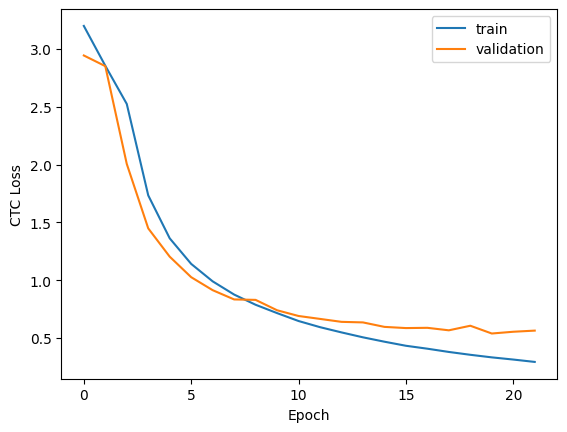

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history["loss"][1:], label="train")
plt.plot(history["val_loss"][1:], label="validation")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")

plt.legend()
plt.show()

In [ ]:
class CTCGreedyDecoder(torch.nn.Module):
  def __init__(self, labels, blank=0):
    super(CTCGreedyDecoder, self).__init__()

    self.labels = labels
    self.blank = blank

  def forward(self, outputs):

    indices = torch.argmax(outputs, dim=-1)
    indices = torch.unique_consecutive(indices, dim=0)
    indices = [token for token in indices if token != self.blank]
    joined = "".join([self.labels[idx] for idx in indices])
    splt = joined.strip().split()

    return " ".join(splt)

greedy_decoder = CTCGreedyDecoder(labels=vocab.get_itos())

In [ ]:
# Рассчет метрик WER & CER
!pip install jiwer -q

from jiwer import wer, cer

model.eval()

wer_scores = []
cer_scores = []

with torch.no_grad():

  for batch in tqdm(valid_loader, desc="Calculating WER & CER scores"):
    val_src, val_tgt = batch[0].to(device), batch[1].to(device)

    for idx in range(val_src.shape[0]):

      y_pred = model(val_src[idx].unsqueeze(0))

      y_pred = greedy_decoder(y_pred)
      y_true = "".join([vocab.get_itos()[i] for i in val_tgt[idx]])

      wer_scores.append(wer(y_pred, y_true))
      cer_scores.append(cer(y_pred, y_true))

wer_score = (sum(wer_scores) / len(wer_scores))
cer_score = (sum(cer_scores) / len(cer_scores))

print(f"\n\n wer score: {wer_score:.2f}, cer score: {cer_score:.2f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.4 MB/s eta 0:00:00


Calculating WER & CER scores:   0%|          | 0/237 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Calculating WER & CER scores: 100%|██████████| 237/237 [12:50<00:00,  3.25s/it]



 wer score: 0.36, cer score: 0.15


In [ ]:
# Показ прогнозов
def show_result(idx):
  y_pred = model(val_src[idx].unsqueeze(0))
  y_pred = greedy_decoder(y_pred)
  y_true = "".join([vocab.get_itos()[i] for i in val_tgt[idx]])

  print(f"pred: {y_pred}")
  print(f"true: {y_true}")

samples = torch.randint(1, 16, (3, ))

for sample in samples:
  show_result(sample)
  print("*" * 100)

pred: that he was chose wat several other was wast promcing peoples the joine the musical society which was to take part in the great festibl and london an extralye here was not only honour for the vi
true: that he was chosen with several other of his most promising pupils to join the musical society which was to take part in the great festival in london the next july here was not only honour for the violinist but happi
****************************************************************************************************
pred: as americans their fally is pecularly scandalas because if the principals they now o pold our right it meas that i would have been better that a mergan should never have achieve their independent and better that
true: as americans their folly is peculiarly scandalous because if the principles they now uphold are right it means that it would have been better that americans should never have achieved their independence and better th
**********************************